# Hate Speech Deep Neural Network Detection
### Author: Blu LeBlanc

The goal of this project is to utilize deep learning to identify social media posts that contain hate speech. This will be a valuable exercise in practicing Natural Language Processing and comparing various text analysis models

WARNING: There may be examples of hateful language displayed for analysis purposes

## Data
The data is described as a curated dataset containing emojis, emoticons, and contractions bundled into two classes, hateful and non-hateful, to detect hate speech in text

- Original Source of data: https://data.mendeley.com/datasets/9sxpkmm8xn/1
- Found and used on Kaggle
- Two associated files:
    - HateSpeechDataset.csv -> 
       201.55 MB
    - HateSpeechDatasetBalanced.csv ->
       145.12 MB

The label column has either 0 or 1

- 0 means "non-hateful"
- 1 means "hateful"

In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import emoji
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
from sklearn.feature_extraction.text import CountVectorizer

## Exploratory Data Analysis

In [2]:
# Load the data
path_2 = '/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDataset.csv'
df_b = pd.read_csv(path_2)

print("Shape: ")
print(df_b.shape)
print("Columns: ")
print(df_b.columns.tolist())
print(df_b.info())
print(df_b.describe())

Shape: 
(440906, 3)
Columns: 
['Content', 'Label', 'Content_int']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440906 entries, 0 to 440905
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Content      440906 non-null  object
 1   Label        440906 non-null  object
 2   Content_int  440906 non-null  object
dtypes: object(3)
memory usage: 10.1+ MB
None
        Content   Label             Content_int
count    440906  440906                  440906
unique   417561       3                  417561
top     content       0  [146715, 7139, 146714]
freq          7  361594                       7


I don't think I will use Content_int for anything. Let's view the label distribution

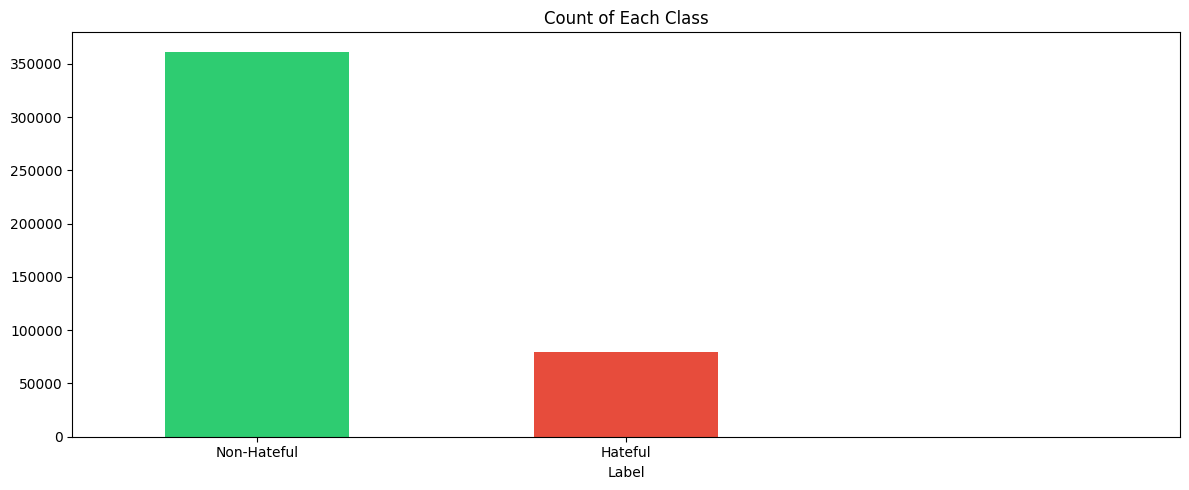

In [3]:
# View Distribution
plt.figure(figsize=(12, 5))
df_b['Label'].value_counts().plot.bar(color=['#2ecc71', '#e74c3c'])
plt.xticks([0, 1], ['Non-Hateful', 'Hateful'], rotation=0)
plt.title('Count of Each Class')
plt.tight_layout()
plt.show()

There is a severe discrepancy in the amount of Non-Hateful text compared to Hateful text. This is a significant issue that can negatively affect my model accuracy. This might be why the HateSpeechDatasetBalanced.csv is provided. Let's load in and check this data. 

Shape: 
(726119, 2)
Columns: 
['Content', 'Label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB
None
               Label
count  726119.000000
mean        0.502018
std         0.499996
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000


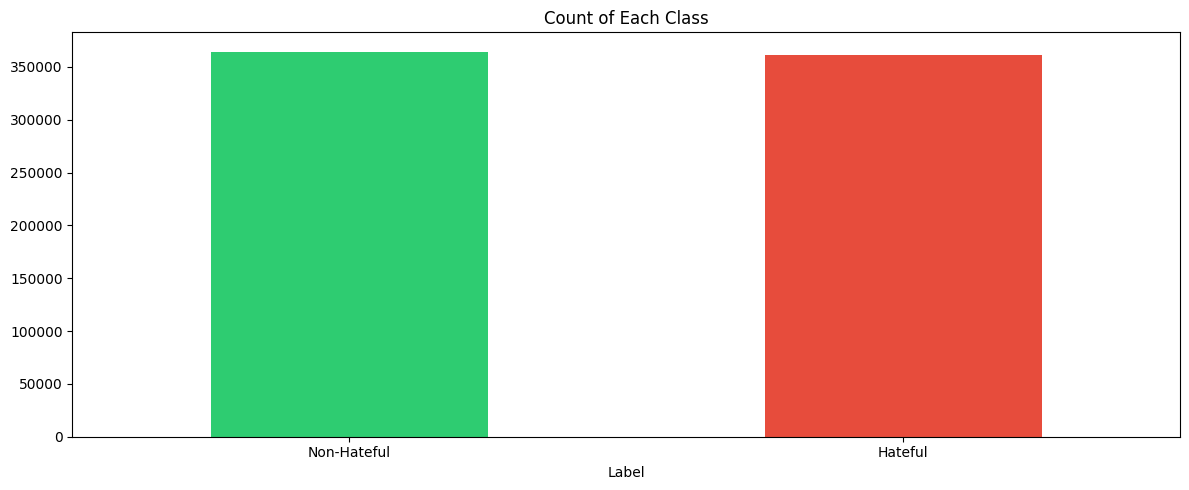

In [4]:
# Load the data
path = '/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv'
df = pd.read_csv(path)

print("Shape: ")
print(df.shape)
print("Columns: ")
print(df.columns.tolist())
print(df.info())
print(df.describe())

plt.figure(figsize=(12, 5))
df['Label'].value_counts().plot.bar(color=['#2ecc71', '#e74c3c'])
plt.xticks([0, 1], ['Non-Hateful', 'Hateful'], rotation=0)
plt.title('Count of Each Class')
plt.tight_layout()
plt.show()

This dataset is closely balanced between the Non-Hateful and Hateful text. The dataset description states that undersampling on Non_Hateful text and augmenting the Hateful text was utilized to balance the classes. Now we will continue our EDA with the balanced dataset.

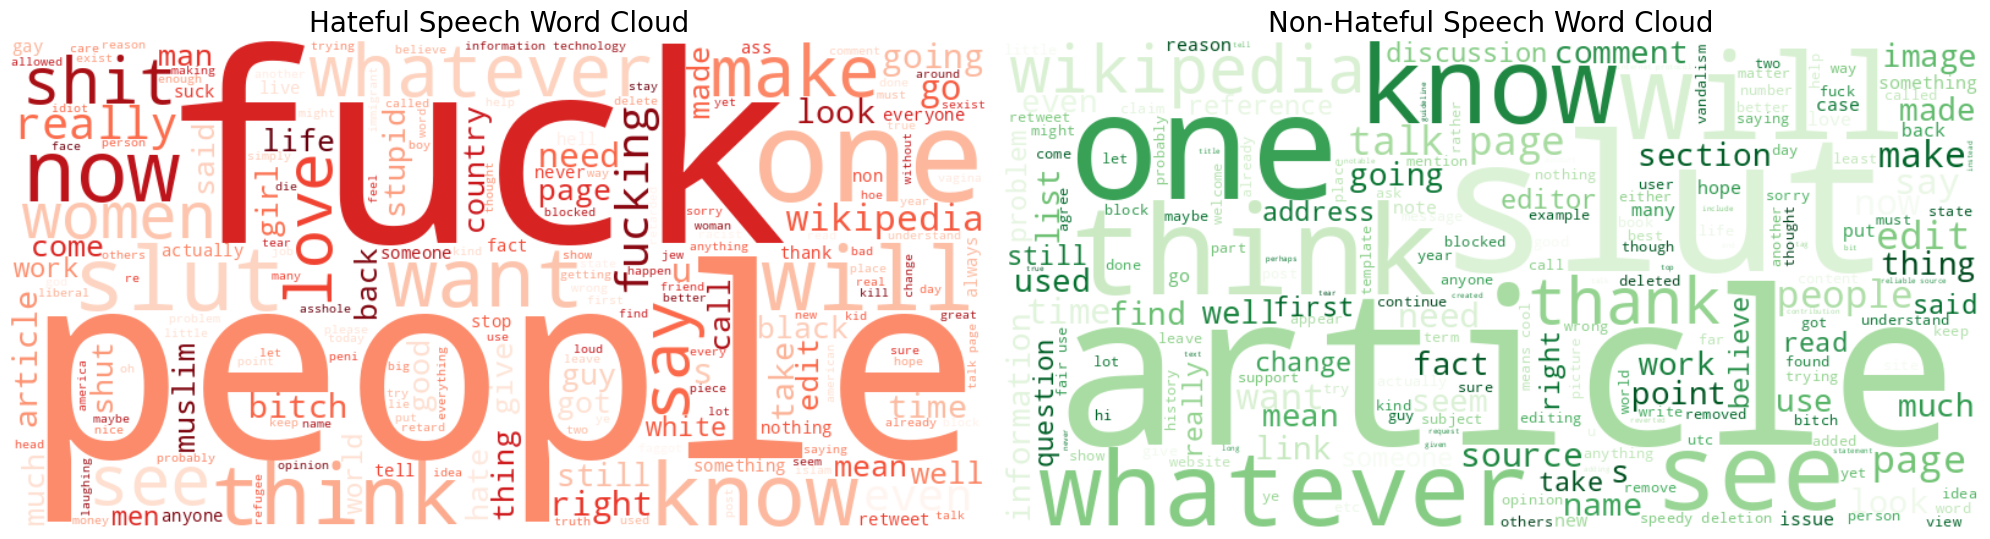

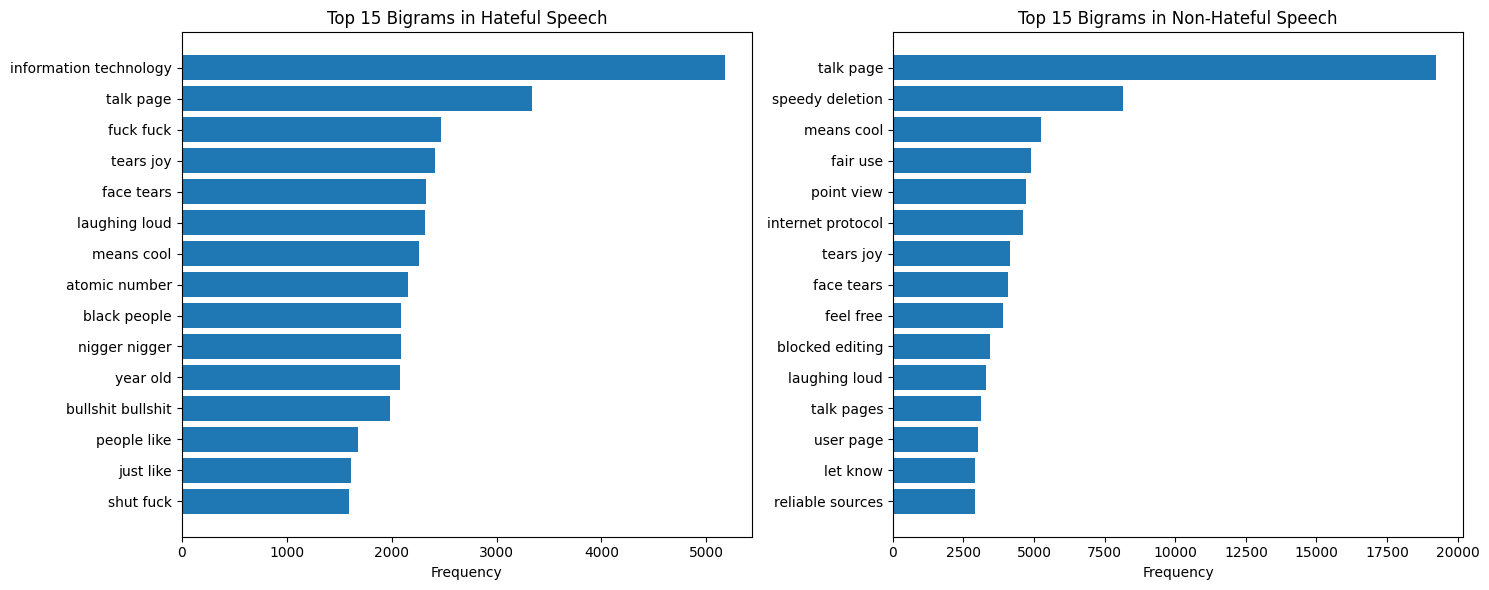

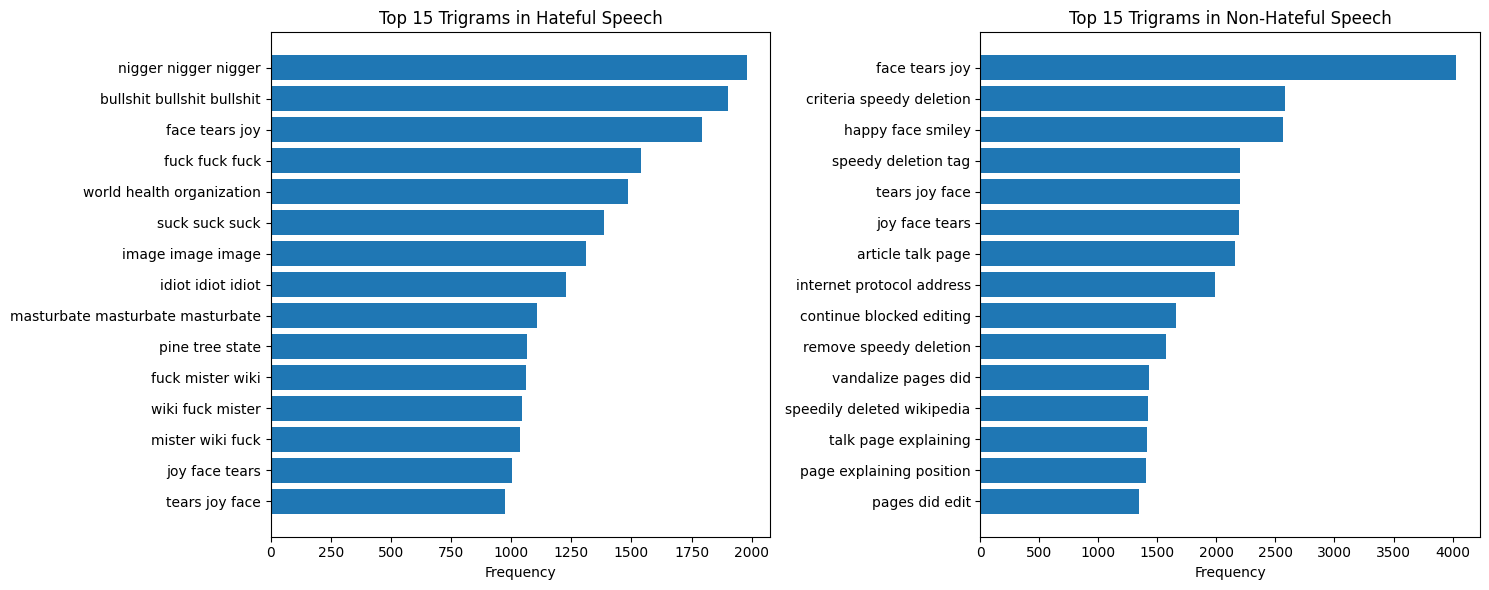

In [5]:
# Word Cloud
hateful_text = ' '.join(df[df['Label'] == 1]['Content'].values)
non_hateful_text = ' '.join(df[df['Label'] == 0]['Content'].values)

# Create subplots for wordclouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

wordcloud_hate = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='Reds').generate(hateful_text)
ax1.imshow(wordcloud_hate, interpolation='bilinear')
ax1.set_title('Hateful Speech Word Cloud', fontsize=20)
ax1.axis('off')

wordcloud_non_hate = WordCloud(width=800, height=400,
                              background_color='white',
                              colormap='Greens').generate(non_hateful_text)
ax2.imshow(wordcloud_non_hate, interpolation='bilinear')
ax2.set_title('Non-Hateful Speech Word Cloud', fontsize=20)
ax2.axis('off')

plt.tight_layout()

# Top words/phrases analysis

def get_top_ngrams(corpus, n=2, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Top bigrams visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, (label, title) in enumerate([(1, 'Hateful'), (0, 'Non-Hateful')]):
    corpus = df[df['Label'] == label]['Content'].values
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=15)
    
    words, counts = zip(*top_bigrams)
    ax[i].barh(words, counts)
    ax[i].set_xlabel('Frequency')
    ax[i].set_title(f'Top 15 Bigrams in {title} Speech')
    ax[i].invert_yaxis()

plt.tight_layout()

# Top trigrams visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, (label, title) in enumerate([(1, 'Hateful'), (0, 'Non-Hateful')]):
    corpus = df[df['Label'] == label]['Content'].values
    top_bigrams = get_top_ngrams(corpus, n=3, top_k=15)
    
    words, counts = zip(*top_bigrams)
    ax[i].barh(words, counts)
    ax[i].set_xlabel('Frequency')
    ax[i].set_title(f'Top 15 Trigrams in {title} Speech')
    ax[i].invert_yaxis()

plt.tight_layout()

The word clouds give us a clear picture of the content of the hateful text vs the non-hateful text. I was particularly interested in the bigrams and trigrams. There are certain word combinations, such as "talk page" that appear very frequently in both class sets. I wonder if I should remove them during my text preprocessing. My understanding is that many times it is better to do minimal text cleaning for deep learning with text, but I am curious. I will perform two versions of text processing: minimal and aggressive and see how my models perform differently

## Text Preprocessing

In [6]:
# NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# function to preprocess text minimally
def p_minimal_text(text):
    # emoji -> text
    text = emoji.demojize(text)
    # keep capitalization
    text = re.sub(r'([A-Z]{2,})', r'ALLCAPS_\1', text)
    text = re.sub(r'([!?.]){2,}', r' MULTIPUNCT ', text)
    # Basic cleaning
    text = re.sub(r'http\S+', 'URL', text)
    text = re.sub(r'@\w+', 'MENTION', text)
    text = re.sub(r'#(\w+)', r'HASHTAG_\1', text)
    return text.lower()

# function to preprocess text aggressively
def p_aggressive_text(text):
    # all lowercase
    text = text.lower()
    # re,pve ;omls
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = text.split()
    # lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# create different texts
df['text_original'] = df['Content']
df['text_minimal'] = df['Content'].apply(lambda x: p_minimal_text(x))
df['text_aggressive'] = df['Content'].apply(lambda x: p_aggressive_text(x))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's make sure all that loaded correctly

In [7]:
df.head()

,Content,Label,text_original,text_minimal,text_aggressive
0,denial of normal the con be asked to comment o...,1,denial of normal the con be asked to comment o...,denial of normal the con be asked to comment o...,denial normal con asked comment tragedy emotio...
1,just by being able to tweet this insufferable ...,1,just by being able to tweet this insufferable ...,just by being able to tweet this insufferable ...,able tweet insufferable bullshit prof trump na...
2,that is retarded you too cute to be single tha...,1,that is retarded you too cute to be single tha...,that is retarded you too cute to be single tha...,retarded cute single life
3,thought of a real badass mongol style declarat...,1,thought of a real badass mongol style declarat...,thought of a real badass mongol style declarat...,thought real badass mongol style declaration w...
4,afro american basho,1,afro american basho,afro american basho,afro american basho


### Model Architecture
My goal for this project is to compare different RNN models to classify text as either "Hateful" or "Non-Hateful." I will compare the LSTM and GRU models we discussed in class, as well as a CNN_LSTM model. Below I will separate our data into train_test_splits and create functions for each of our models.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# USE SUBSET OR NOT FOR INITIAL MODEL COMPARISONS
USE_SUBSET = True  # Set false for full training
SUBSET_FRACTION = 0.3  # Use 10% of data

# Data Preparation
# X1 is for minimal cleaning, X2 is for aggressive cleaning
X1 = df['text_minimal'].values
X2 = df['text_aggressive'].values  # Added .values
y = df['Label'].values


# splitting indices
n_samples = len(y)
indices = np.arange(n_samples)

# if using subset
if USE_SUBSET:
    subset_size = int(SUBSET_FRACTION * n_samples)
    # Stratified sampling to maintain class balance
    subset_indices = []
    for label in np.unique(y):
        label_indices = indices[y == label]
        n_subset = int(SUBSET_FRACTION * len(label_indices))
        subset_indices.extend(np.random.choice(label_indices, n_subset, replace=False))
    
    subset_indices = np.array(subset_indices)
    np.random.shuffle(subset_indices)
    
    # Apply subset
    X1 = X1[subset_indices]
    X2 = X2[subset_indices]
    y = y[subset_indices]
    indices = np.arange(len(y))
    
    print(f"Using {SUBSET_FRACTION*100}% subset: {len(y)} samples")
    print(f"Class distribution in subset: {np.bincount(y)}")



# Split indices instead of data
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices, y, test_size=0.3, random_state=42, stratify=y
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y[temp_idx], test_size=0.5, random_state=42, stratify=y[temp_idx]
)

# Now apply the same splits to both X1 and X2
X1_train = X1[train_idx]
X1_val = X1[val_idx]
X1_test = X1[test_idx]

X2_train = X2[train_idx]
X2_val = X2[val_idx]
X2_test = X2[test_idx]

print(f"Train set: {len(X1_train)} samples")
print(f"Validation set: {len(X1_val)} samples")
print(f"Test set: {len(X1_test)} samples")

print(f"Train set: {len(X2_train)} samples")
print(f"Validation set: {len(X2_val)} samples")
print(f"Test set: {len(X2_test)} samples")

max_words = 10000
max_len = 150

# Create separate tokenizers for each preprocessing approach
tokenizer1 = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer1.fit_on_texts(X1_train)

tokenizer2 = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer2.fit_on_texts(X2_train)

# Convert to sequences using tokenizers
X1_train_seq = tokenizer1.texts_to_sequences(X1_train)
X1_val_seq = tokenizer1.texts_to_sequences(X1_val)
X1_test_seq = tokenizer1.texts_to_sequences(X1_test)

X2_train_seq = tokenizer2.texts_to_sequences(X2_train)
X2_val_seq = tokenizer2.texts_to_sequences(X2_val)
X2_test_seq = tokenizer2.texts_to_sequences(X2_test)

# Padding
max_len = 150

X1_train_pad = pad_sequences(X1_train_seq, maxlen=max_len, padding='post')
X1_val_pad = pad_sequences(X1_val_seq, maxlen=max_len, padding='post')
X1_test_pad = pad_sequences(X1_test_seq, maxlen=max_len, padding='post')

X2_train_pad = pad_sequences(X2_train_seq, maxlen=max_len, padding='post')
X2_val_pad = pad_sequences(X2_val_seq, maxlen=max_len, padding='post')
X2_test_pad = pad_sequences(X2_test_seq, maxlen=max_len, padding='post')


2025-07-27 02:29:42.926327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753583383.153603      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753583383.210622      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using 30.0% subset: 217835 samples
Class distribution in subset: [108478 109357]
Train set: 152484 samples
Validation set: 32675 samples
Test set: 32676 samples
Train set: 152484 samples
Validation set: 32675 samples
Test set: 32676 samples


In [9]:
# Model Architectures
def create_lstm_model(embedding_dim=128, lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_cnn_lstm_model(embedding_dim=128, filters=64, kernel_size=5, 
                         lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Conv1D(filters, kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units, dropout=dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_gru_model(embedding_dim=128, gru_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(GRU(gru_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model


Finally, let's train our models on both of our X data


Model: LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1753583408.252343      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM with minimal preprocessing...
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 128s 397ms/step - accuracy: 0.5175 - loss: 0.6884 - precision: 0.5122 - recall: 0.7443 - val_accuracy: 0.5285 - val_loss: 0.6795 - val_precision: 0.5159 - val_recall: 0.9893 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 119s 398ms/step - accuracy: 0.5273 - loss: 0.6791 - precision: 0.5157 - recall: 0.9303 - val_accuracy: 0.5299 - val_loss: 0.6795 - val_precision: 0.5165 - val_recall: 0.9963 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 118s 396ms/step - accuracy: 0.5363 - loss: 0.6740 - precision: 0.5205 - recall: 0.9761 - val_accuracy: 0.7489 - val_loss: 0.5310 - val_precision: 0.7224 - val_recall: 0.8119 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 118s 396ms/step - accuracy: 0.7724 - loss: 0.5012 - precision: 0.7377 - recall: 0.8513 - val_accuracy: 0.8264 - val_loss: 0.3833 - val_precision: 0.8225 - val_recall: 0.8343 - learning_rate: 0.0010
Epo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training CNN-LSTM with minimal preprocessing...
Epoch 1/10


I0000 00:00:1753584598.663833      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.6111 - loss: 0.6514 - precision_1: 0.5810 - recall_1: 0.7999 - val_accuracy: 0.6975 - val_loss: 0.5874 - val_precision_1: 0.6368 - val_recall_1: 0.9250 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6527 - loss: 0.6274 - precision_1: 0.6675 - recall_1: 0.6196 - val_accuracy: 0.7196 - val_loss: 0.5661 - val_precision_1: 0.7016 - val_recall_1: 0.7682 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7541 - loss: 0.5215 - precision_1: 0.7264 - recall_1: 0.8181 - val_accuracy: 0.8119 - val_loss: 0.4211 - val_precision_1: 0.7758 - val_recall_1: 0.8794 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8200 - loss: 0.4188 - precision_1: 0.7969 - recall_1: 0.8598 - val_accuracy: 0.8209 - val_loss: 0.3983 - val_precision_1: 0.8041 - val_recall_1: 0.8503 - learning_rate: 0.0010
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training GRU with minimal preprocessing...
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 173s 552ms/step - accuracy: 0.6713 - loss: 0.5816 - precision_2: 0.6524 - recall_2: 0.7658 - val_accuracy: 0.8239 - val_loss: 0.3868 - val_precision_2: 0.8085 - val_recall_2: 0.8507 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 163s 548ms/step - accuracy: 0.8262 - loss: 0.3956 - precision_2: 0.8052 - recall_2: 0.8601 - val_accuracy: 0.8306 - val_loss: 0.3678 - val_precision_2: 0.8097 - val_recall_2: 0.8661 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 162s 545ms/step - accuracy: 0.8391 - loss: 0.3661 - precision_2: 0.8190 - recall_2: 0.8737 - val_accuracy: 0.8340 - val_loss: 0.3623 - val_precision_2: 0.8209 - val_recall_2: 0.8560 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 163s 546ms/step - accuracy: 0.8483 - loss: 0.3474 - precision_2: 0.8277 - recall_2: 0.8805 - val_accuracy: 0.8336 - val_loss: 0.3610 - val_precision_2: 0.8110 - val_recall_2: 0.8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,994,565 (15.24 MB)

 Trainable params: 1,331,521 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,663,044 (10.16 MB)


Training LSTM with aggressive preprocessing...
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 126s 404ms/step - accuracy: 0.6164 - loss: 0.6597 - precision_3: 0.5939 - recall_3: 0.7591 - val_accuracy: 0.7947 - val_loss: 0.4354 - val_precision_3: 0.7589 - val_recall_3: 0.8661 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 119s 400ms/step - accuracy: 0.8049 - loss: 0.4345 - precision_3: 0.7744 - recall_3: 0.8621 - val_accuracy: 0.8112 - val_loss: 0.4060 - val_precision_3: 0.7798 - val_recall_3: 0.8696 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 120s 403ms/step - accuracy: 0.8212 - loss: 0.4056 - precision_3: 0.7911 - recall_3: 0.8753 - val_accuracy: 0.8143 - val_loss: 0.3990 - val_precision_3: 0.7811 - val_recall_3: 0.8756 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 120s 403ms/step - accuracy: 0.8289 - loss: 0.3860 - precision_3: 0.7949 - recall_3: 0.8900 - val_accuracy: 0.8159 - val_loss: 0.3968 - val_precision_3: 0.7909 - val_recall_3:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 146, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,485 (15.52 MB)

 Trainable params: 1,356,161 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,712,324 (10.35 MB)


Training CNN-LSTM with aggressive preprocessing...
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.6309 - loss: 0.6615 - precision_4: 0.5981 - recall_4: 0.8259 - val_accuracy: 0.7856 - val_loss: 0.5044 - val_precision_4: 0.7411 - val_recall_4: 0.8806 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7968 - loss: 0.4792 - precision_4: 0.7513 - recall_4: 0.8918 - val_accuracy: 0.8051 - val_loss: 0.4279 - val_precision_4: 0.7593 - val_recall_4: 0.8957 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8201 - loss: 0.4115 - precision_4: 0.7754 - recall_4: 0.9009 - val_accuracy: 0.8099 - val_loss: 0.4172 - val_precision_4: 0.7896 - val_recall_4: 0.8469 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8354 - loss: 0.3815 - precision_4: 0.7948 - recall_4: 0.9048 - val_accuracy: 0.8123 - val_loss: 0.4221 - val_precision_4: 0.7736 - val_recall_4: 0.8851

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,075,973 (15.55 MB)

 Trainable params: 1,358,657 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,717,316 (10.37 MB)


Training GRU with aggressive preprocessing...
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 170s 544ms/step - accuracy: 0.6032 - loss: 0.6921 - precision_5: 0.6084 - recall_5: 0.5770 - val_accuracy: 0.7989 - val_loss: 0.4292 - val_precision_5: 0.7660 - val_recall_5: 0.8631 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 202s 544ms/step - accuracy: 0.8118 - loss: 0.4267 - precision_5: 0.7944 - recall_5: 0.8433 - val_accuracy: 0.8152 - val_loss: 0.4013 - val_precision_5: 0.7994 - val_recall_5: 0.8435 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 162s 543ms/step - accuracy: 0.8265 - loss: 0.3905 - precision_5: 0.8063 - recall_5: 0.8594 - val_accuracy: 0.8175 - val_loss: 0.3955 - val_precision_5: 0.8049 - val_recall_5: 0.8402 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 161s 540ms/step - accuracy: 0.8368 - loss: 0.3686 - precision_5: 0.8149 - recall_5: 0.8735 - val_accuracy: 0.8201 - val_loss: 0.3907 - val_precision_5: 0.7959 - val_recall_5: 

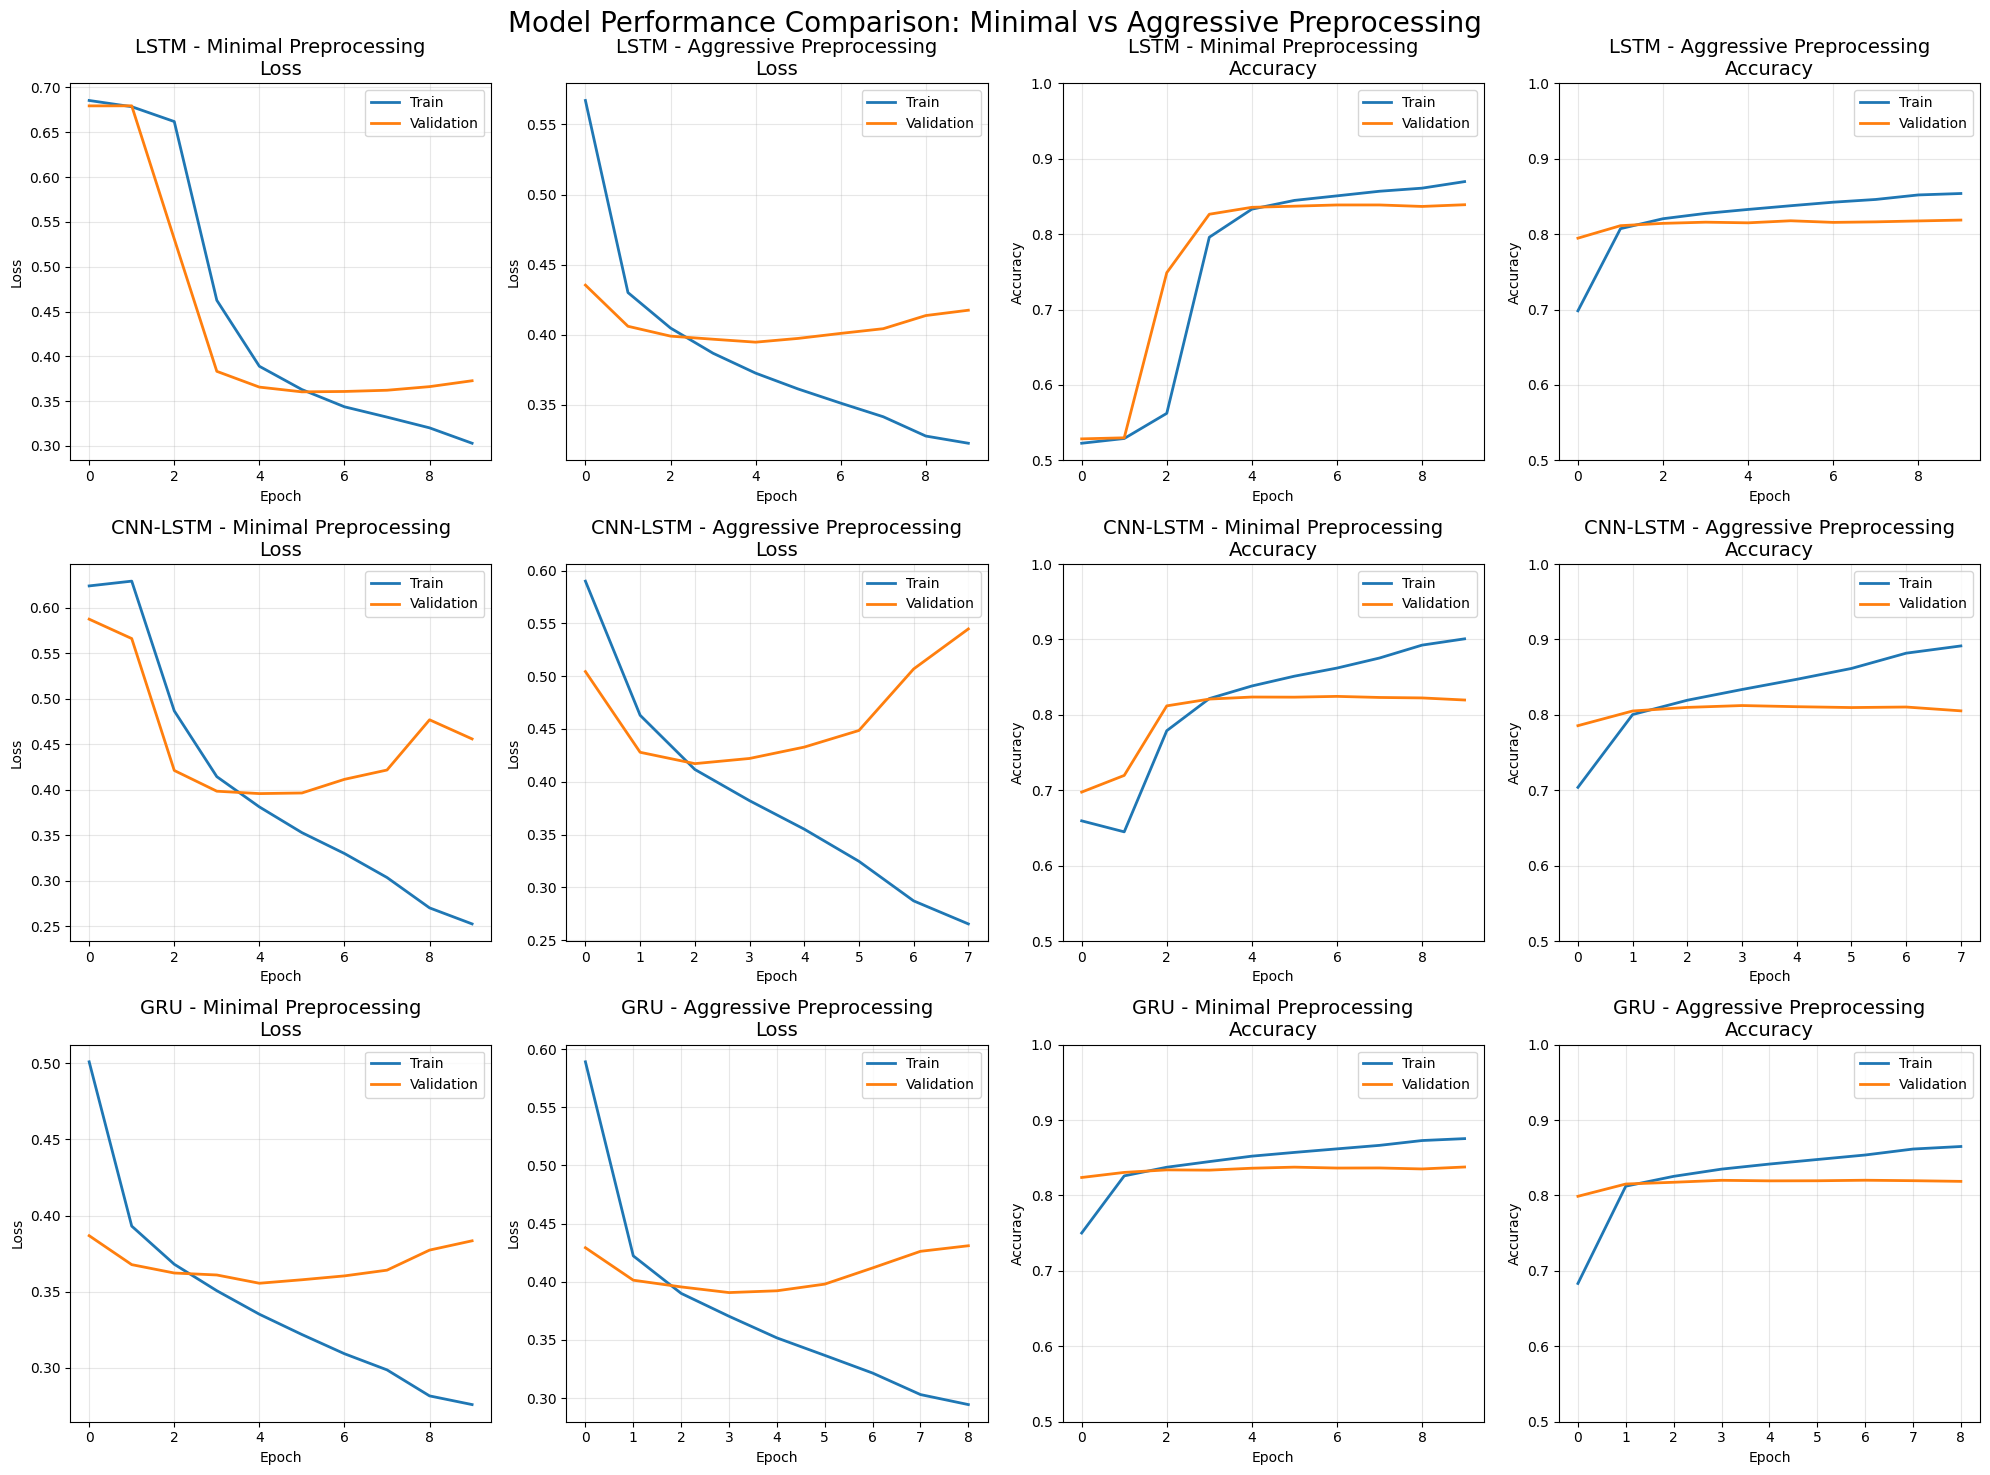

In [10]:
# Training function with visualization
def train_model(model, model_name, epochs=10, batch_size=512):
    print(f"\nTraining {model_name} with minimal preprocessing...")
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), 
               tf.keras.metrics.Recall()]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f'{model_name}_minimal_best.h5', monitor='val_loss', save_best_only=True)
    ]
    
    history = model.fit(
        X1_train_pad, y_train,  # Using X1 data
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X1_val_pad, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

       # metrics=['accuracy', tf.keras.metrics.Precision(), 
            #    tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]

def train2_model(model, model_name, epochs=10, batch_size=512):
    print(f"\nTraining {model_name} with aggressive preprocessing...")
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy' , tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f'{model_name}_aggressive_best.h5', monitor='val_loss', save_best_only=True)
    ]
    
    history = model.fit(
        X2_train_pad, y_train,  # Using X2 data
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X2_val_pad, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Train multiple models
models = {
    'LSTM': create_lstm_model(),
    'CNN-LSTM': create_cnn_lstm_model(),
    'GRU': create_gru_model()
}

histories = {}
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    model.summary()
    histories[name] = train_model(model, name)

histories2 = {}
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    model.summary()
    histories2[name] = train2_model(model, name)

# Plots to visualize basic performance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Individual Model Performance Plots (Loss and Accuracy)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Model Performance Comparison: Minimal vs Aggressive Preprocessing', fontsize=20)

models_list = list(models.keys())

for idx, model_name in enumerate(models_list):
    # Loss plots
    # Minimal preprocessing
    axes[idx, 0].plot(histories[model_name].history['loss'], label='Train', linewidth=2)
    axes[idx, 0].plot(histories[model_name].history['val_loss'], label='Validation', linewidth=2)
    axes[idx, 0].set_title(f'{model_name} - Minimal Preprocessing\nLoss', fontsize=14)
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Aggressive preprocessing
    axes[idx, 1].plot(histories2[model_name].history['loss'], label='Train', linewidth=2)
    axes[idx, 1].plot(histories2[model_name].history['val_loss'], label='Validation', linewidth=2)
    axes[idx, 1].set_title(f'{model_name} - Aggressive Preprocessing\nLoss', fontsize=14)
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Loss')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Accuracy plots
    # Minimal preprocessing
    axes[idx, 2].plot(histories[model_name].history['accuracy'], label='Train', linewidth=2)
    axes[idx, 2].plot(histories[model_name].history['val_accuracy'], label='Validation', linewidth=2)
    axes[idx, 2].set_title(f'{model_name} - Minimal Preprocessing\nAccuracy', fontsize=14)
    axes[idx, 2].set_xlabel('Epoch')
    axes[idx, 2].set_ylabel('Accuracy')
    axes[idx, 2].legend()
    axes[idx, 2].grid(True, alpha=0.3)
    axes[idx, 2].set_ylim(0.5, 1.0)
    
    # Aggressive preprocessing
    axes[idx, 3].plot(histories2[model_name].history['accuracy'], label='Train', linewidth=2)
    axes[idx, 3].plot(histories2[model_name].history['val_accuracy'], label='Validation', linewidth=2)
    axes[idx, 3].set_title(f'{model_name} - Aggressive Preprocessing\nAccuracy', fontsize=14)
    axes[idx, 3].set_xlabel('Epoch')
    axes[idx, 3].set_ylabel('Accuracy')
    axes[idx, 3].legend()
    axes[idx, 3].grid(True, alpha=0.3)
    axes[idx, 3].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

NOTE: I encountered issues with the amount of time it takes to train the models. Since I am focused on finding the best model and am training many models together, I changed the batch size to be 512. I also decided to do my model comparison with a subset of the data. Chosen 30% of the data

## Analysis
Let's analyze our graphs and determine the best model, best preprocessing strategy, and other insights. Remember that this was conducted on a small sample of the entire dataset (30%), which could have an effect on the results

- Across all models, minimal text processing performed better than aggressive text processing
 - Confirms that keeping punctuation, emojis, and capitalization gives better performance
- There are some overfitting issues. This issue will hopefully be mitigated with using the entire dataset and using less epochs
- Most of the models converge within 6 epochs
- Sharp accuracy jump within 2-3 epochs
- CNN_LSTM worked significantly faster

MODEL VALIDATION ACCURACIES: 
- LSTM: val_accuracy: 0.8320
- CNN_LSTM: val_accuracy: 0.8222
- GRU: val_accuracy: 0.8344

## Model Choice
First and foremost, I will be using minimal processing of the text for my full model. Overall, I decided that I valued the speed increase that the CNN_LSTM model provides over the increased validation accuracy from the GRU model. If I had a stronger system or more time, I may have chosen to work with GRU, but having 24 ms/step is way better than having 530 ms/step. The time issue will be a much bigger factor when dealing with the entire dataset. I will train the full model over 6 epochs based on my graphs. I also need to monitor the training to make sure there is no instability. Based on my validation plots, the CNN_LSTM method seems somewhat unstable.

## Final Model

In [11]:
# Getting full data
# USE SUBSET OR NOT FOR INITIAL MODEL COMPARISONS
USE_SUBSET = False  # Set false for full training
SUBSET_FRACTION = 0.3  # Use 10% of data

# Data Preparation
X = df['text_minimal'].values
y = df['Label'].values


# splitting indices
n_samples = len(y)
indices = np.arange(n_samples)



# Split indices
train_idx, temp_idx, y_train_full, y_temp_full = train_test_split(
    indices, y, test_size=0.3, random_state=42, stratify=y
)
val_idx, test_idx, y_val_full, y_test_full = train_test_split(
    temp_idx, y[temp_idx], test_size=0.5, random_state=42, stratify=y[temp_idx]
)

# Now apply the same splits to both X1 and X2
X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

assert len(X_train) == len(y_train), f"Train mismatch: X={len(X_train)}, y={len(y_train)}"
assert len(X_val) == len(y_val), f"Val mismatch: X={len(X_val)}, y={len(y_val)}"
assert len(X_test) == len(y_test), f"Test mismatch: X={len(X_test)}, y={len(y_test)}"

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

max_words = 10000
max_len = 150

# Create separate tokenizers for each preprocessing approach
tokenizer1 = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer1.fit_on_texts(X_train)

# Convert to sequences using tokenizers
X_train_seq = tokenizer1.texts_to_sequences(X_train)
X_val_seq = tokenizer1.texts_to_sequences(X_val)
X_test_seq = tokenizer1.texts_to_sequences(X_test)

# Padding
max_len = 150

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Train set: 508283 samples
Validation set: 108918 samples
Test set: 108918 samples


In [12]:
# Initialize model
final_model = create_cnn_lstm_model()

# Compile with optimal settings
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
model.summary()

# calculate f1 score
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# callbacks
callbacks = [
    # early stopping for epochs 5-6
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    
    # save best model
    ModelCheckpoint(
        'final_model_results/best_cnn_lstm_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Training parameters
BATCH_SIZE = 512 
EPOCHS = 10 # will stop early

print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history = final_model.fit(
    X_train_pad, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)




Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,075,973 (15.55 MB)

 Trainable params: 1,358,657 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,717,316 (10.37 MB)


STARTING TRAINING...
Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7524 - auc: 0.8276 - loss: 0.4883 - precision: 0.7256 - recall: 0.8279
Epoch 1: val_auc improved from -inf to 0.91853, saving model to final_model_results/best_cnn_lstm_model.h5
993/993 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.7524 - auc: 0.8277 - loss: 0.4882 - precision: 0.7257 - recall: 0.8279 - val_accuracy: 0.8375 - val_auc: 0.9185 - val_loss: 0.3603 - val_precision: 0.8393 - val_recall: 0.8365 - learning_rate: 0.0010
Epoch 2/10
991/993 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8475 - auc: 0.9240 - loss: 0.3490 - precision: 0.8318 - recall: 0.8729
Epoch 2: val_auc improved from 0.91853 to 0.92759, saving model to final_model_results/best_cnn_lstm_model.h5
993/993 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.8475 - auc: 0.9240 - loss: 0.3490 - precision: 0.8318 - recall: 0.8729 - val_accuracy: 0.8473 - val_auc: 0.9276 - val_loss: 0.3400 - val_precision: 0.8392 - val_recall: 0.

In [13]:
# evaluate on test set
test_results = model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE, verbose=1)

print("\nTest Set Performance:")
for metric, value in zip(model.metrics_names, test_results):
    print(f"{metric}: {value:.4f}")

# predictions
y_pred_proba = final_model.predict(X_test_pad, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Hateful', 'Hateful'],
                          digits=4))


213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.5362 - loss: 1.0022 - precision_5: 0.5479 - recall_5: 0.4340

Test Set Performance:
loss: 1.0026
compile_metrics: 0.5364
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

 Non-Hateful     0.8700    0.8439    0.8567     54239
     Hateful     0.8497    0.8749    0.8621     54679

    accuracy                         0.8595    108918
   macro avg     0.8598    0.8594    0.8594    108918
weighted avg     0.8598    0.8595    0.8594    108918



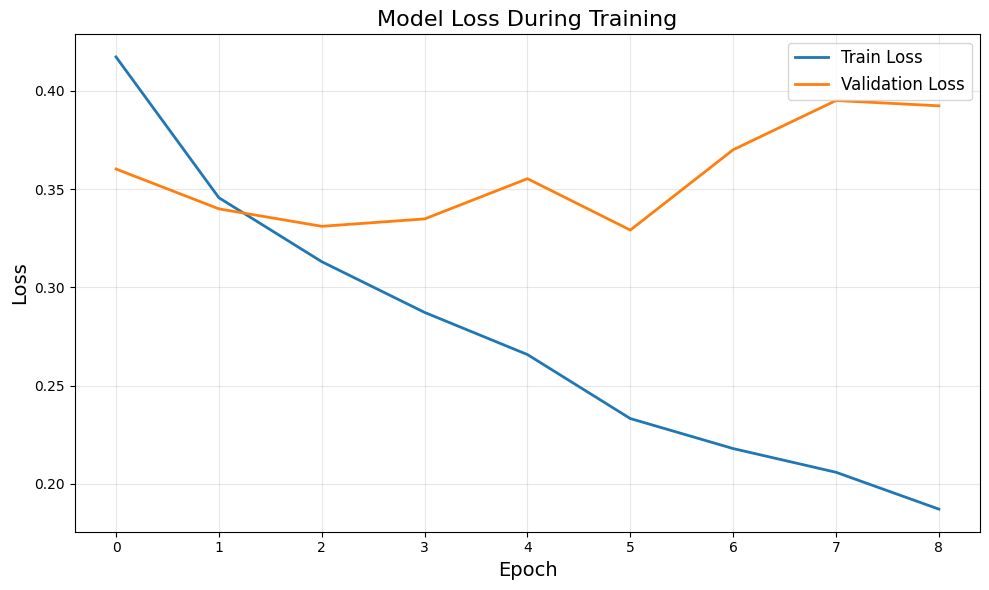

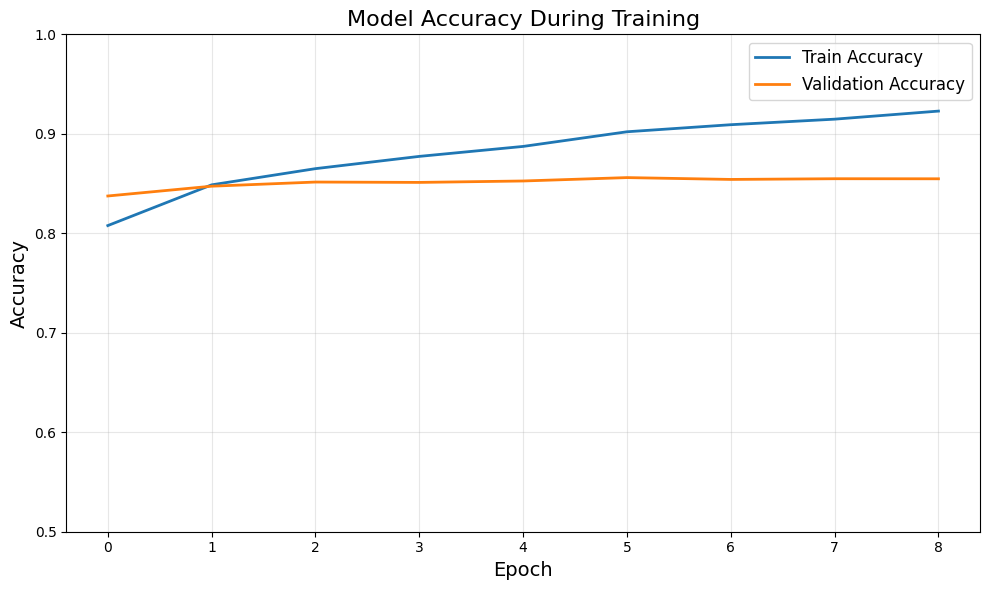

In [14]:
# Training plots: loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

Text(70.72222222222221, 0.5, 'True Label')

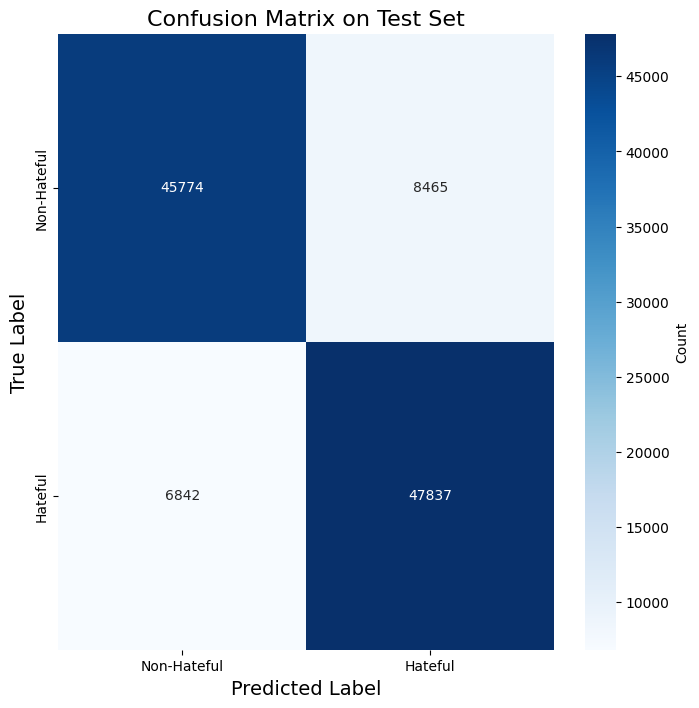

In [15]:
# Confusion Matrix
plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hateful', 'Hateful'],
            yticklabels=['Non-Hateful', 'Hateful'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix on Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

<Figure size 1200x700 with 0 Axes>

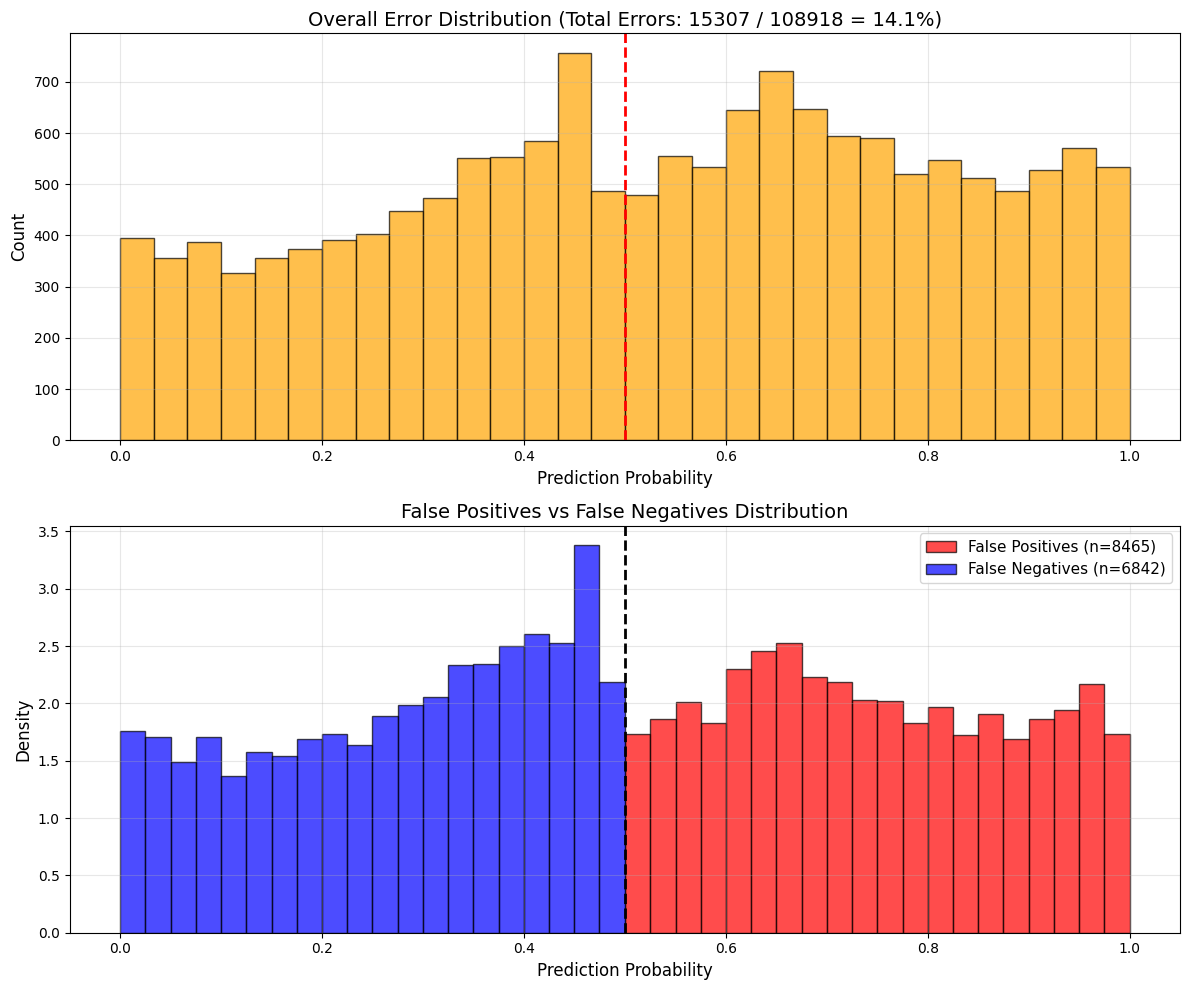

In [16]:
plt.figure(figsize=(12, 7))

# Get misclassified samples
errors = y_test != y_pred
error_proba = y_pred_proba[errors].flatten()
false_positives = y_pred_proba[(y_test == 0) & (y_pred == 1)]
false_negatives = y_pred_proba[(y_test == 1) & (y_pred == 0)]

# Create subplots for different error types
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# Overall error distribution
ax1.hist(error_proba, bins=30, color='orange', alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Overall Error Distribution (Total Errors: {sum(errors)} / {len(y_test)} = {sum(errors)/len(y_test)*100:.1f}%)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Error types comparison
ax2.hist(false_positives, bins=20, alpha=0.7, label=f'False Positives (n={len(false_positives)})', 
         color='red', density=True, edgecolor='black')
ax2.hist(false_negatives, bins=20, alpha=0.7, label=f'False Negatives (n={len(false_negatives)})', 
         color='blue', density=True, edgecolor='black')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('False Positives vs False Negatives Distribution', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion
My model had an overall performance accuracy of 85.3%. Most of the mispredicted errors lie in the 0.4 - 0.6 probability range, which is expected. The model can catch 87% of all "Hateful" posts. Unfortunately, there are 8942 false positives and 7069 false negative cases. If this model were for a product, I would be very unsatisfied with the performance due to the number of false positives. Let's try a deeper CNN_LSTM model and see if there are improvements

## Improved CNN_LSTM Architecture


Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,075,973 (15.55 MB)

 Trainable params: 1,358,657 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,717,316 (10.37 MB)


STARTING TRAINING...
Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7526 - auc: 0.8334 - loss: 0.4763 - precision: 0.7399 - recall: 0.7809
Epoch 1: val_auc improved from -inf to 0.93373, saving model to final_model_results/best_cnn_lstm_model.h5
993/993 ━━━━━━━━━━━━━━━━━━━━ 324s 312ms/step - accuracy: 0.7527 - auc: 0.8335 - loss: 0.4763 - precision: 0.7400 - recall: 0.7809 - val_accuracy: 0.8474 - val_auc: 0.9337 - val_loss: 0.3428 - val_precision: 0.8689 - val_recall: 0.8197 - learning_rate: 0.0010
Epoch 2/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8702 - auc: 0.9443 - loss: 0.2999 - precision: 0.8575 - recall: 0.8895
Epoch 2: val_auc improved from 0.93373 to 0.94331, saving model to final_model_results/best_cnn_lstm_model.h5
993/993 ━━━━━━━━━━━━━━━━━━━━ 309s 311ms/step - accuracy: 0.8702 - auc: 0.9443 - loss: 0.2999 - precision: 0.8575 - recall: 0.8895 - val_accuracy: 0.8631 - val_auc: 0.9433 - val_loss: 0.3127 - val_precision: 0.8768 - val_reca

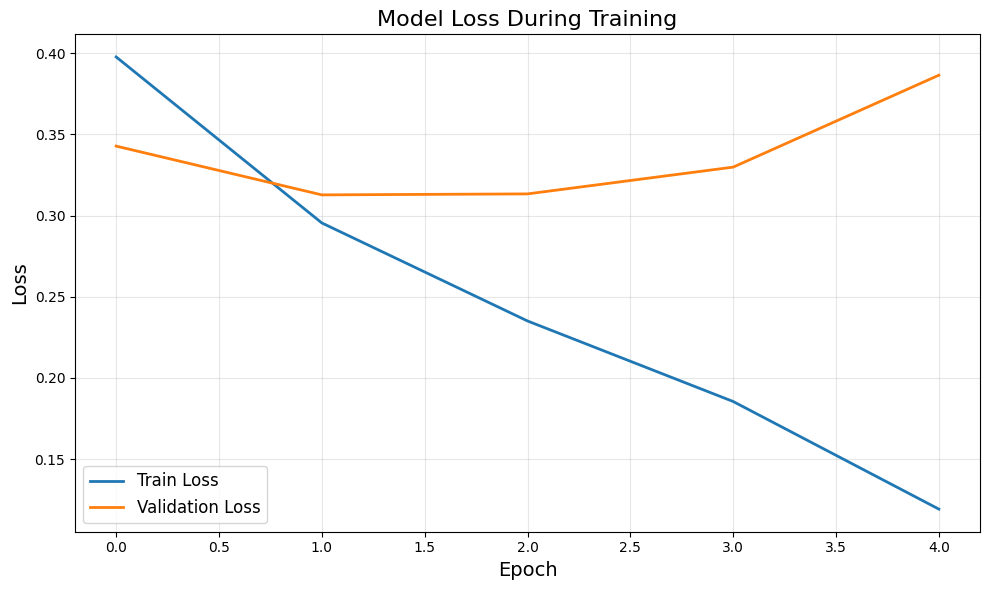

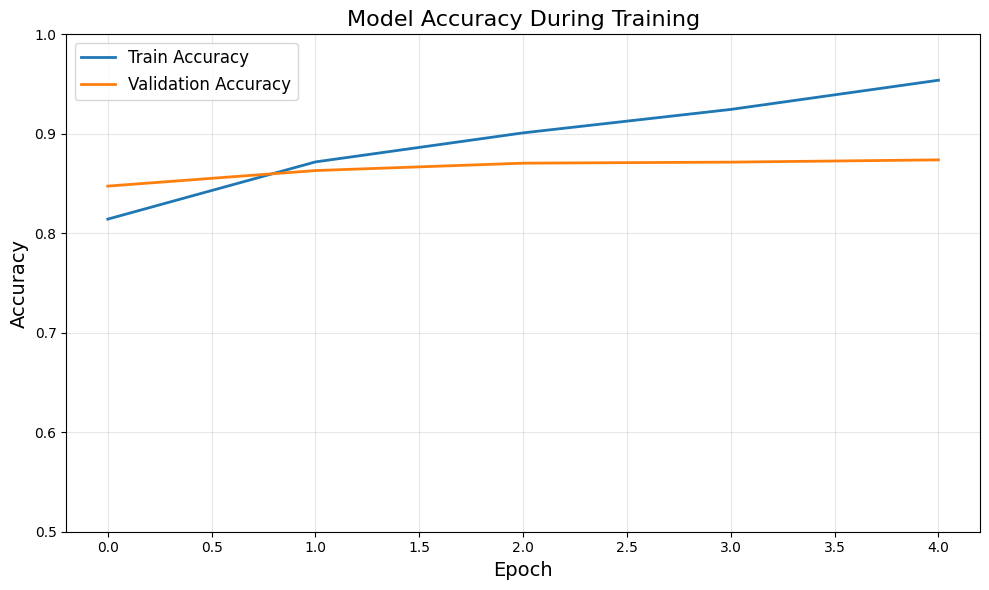

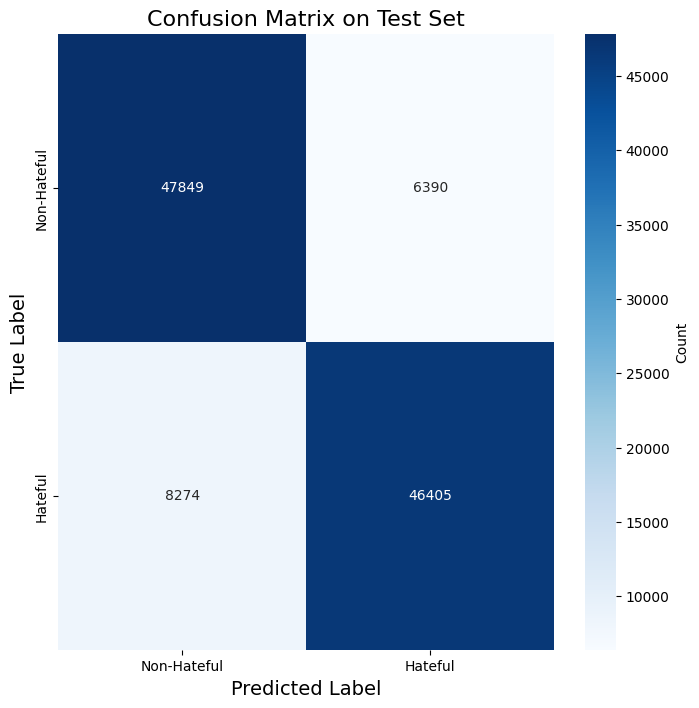

<Figure size 1200x700 with 0 Axes>

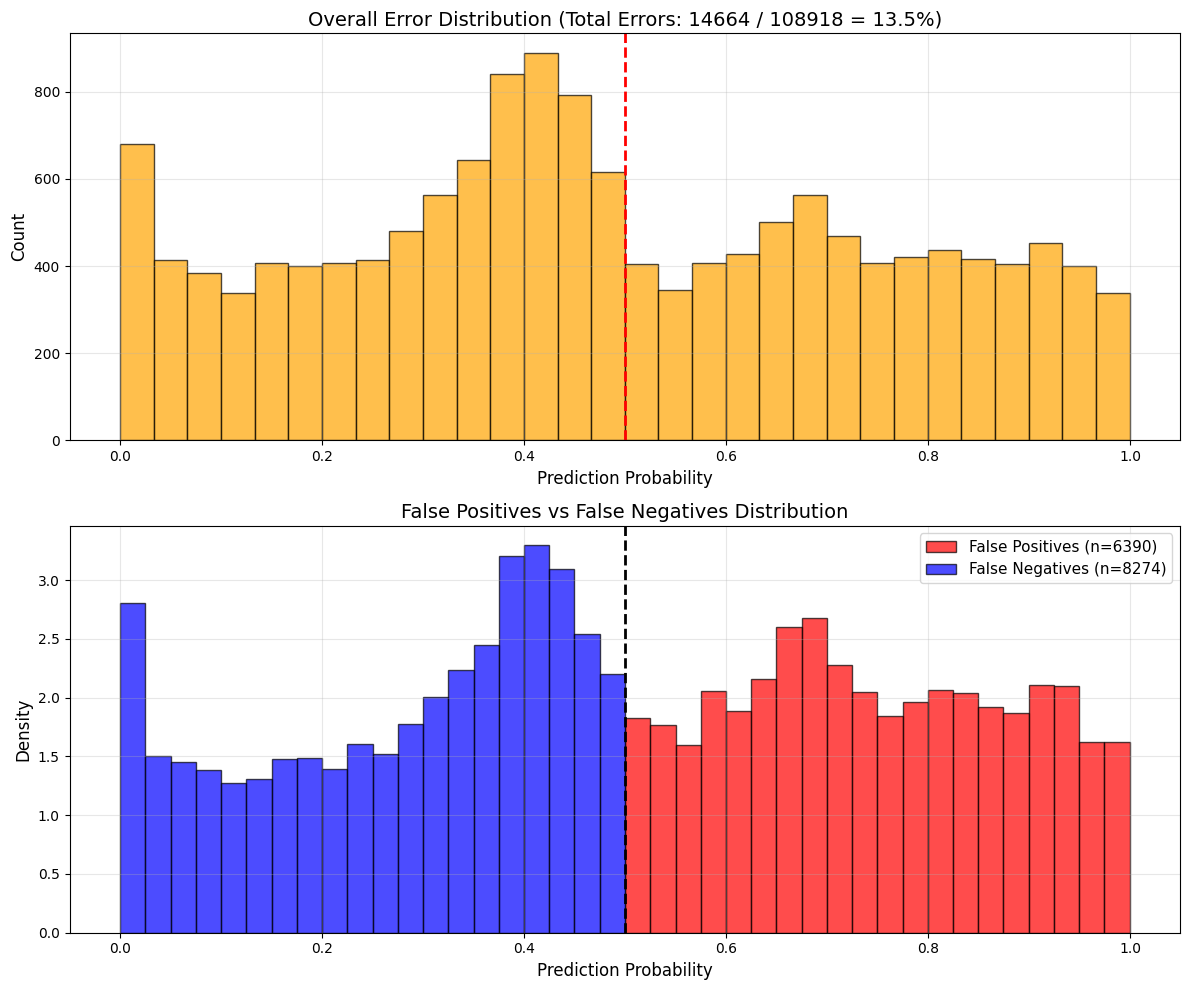

In [17]:
MAX_WORDS = 10000
# Improved CNN_LSTM
def optimized_cnn_lstm_model():
    model = Sequential([
    # Embedding
    Embedding(max_words, 128, input_length=max_len, name='embedding'),
    Conv1D(128, 5, activation='relu', name='conv1'),
    BatchNormalization(name='bn1'),
    MaxPooling1D(pool_size=2, name='maxpool1'),
    # another CNN layer
    Conv1D(64, 3, activation='relu', name='conv2'),
    BatchNormalization(name='bn2'),
    # bidirectionLSTM
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.3), name='bilstm'),
    Dense(64, activation='relu', name='dense1'),
    Dropout(0.4, name='dropout1'),
    Dense(32, activation='relu', name='dense2'),
    Dropout(0.3, name='dropout2'),
    Dense(1, activation='sigmoid', name='output')
    ])

    return model

# Initialize model
final_model = optimized_cnn_lstm_model()

# Compile with optimal settings
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
model.summary()

# calculate f1 score
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# callbacks
callbacks = [
    # early stopping for epochs 5-6
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    
    # save best model
    ModelCheckpoint(
        'final_model_results/best_cnn_lstm_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Training parameters
BATCH_SIZE = 512 
EPOCHS = 10 # will stop early

print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history = final_model.fit(
    X_train_pad, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

# evaluate on test set
test_results = model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE, verbose=1)

print("\nTest Set Performance:")
for metric, value in zip(model.metrics_names, test_results):
    print(f"{metric}: {value:.4f}")

# predictions
y_pred_proba = final_model.predict(X_test_pad, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Hateful', 'Hateful'],
                          digits=4))

# Training plots: loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hateful', 'Hateful'],
            yticklabels=['Non-Hateful', 'Hateful'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix on Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.figure(figsize=(12, 7))

# Get misclassified samples
errors = y_test != y_pred
error_proba = y_pred_proba[errors].flatten()
false_positives = y_pred_proba[(y_test == 0) & (y_pred == 1)]
false_negatives = y_pred_proba[(y_test == 1) & (y_pred == 0)]

# Create subplots for different error types
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# Overall error distribution
ax1.hist(error_proba, bins=30, color='orange', alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Overall Error Distribution (Total Errors: {sum(errors)} / {len(y_test)} = {sum(errors)/len(y_test)*100:.1f}%)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Error types comparison
ax2.hist(false_positives, bins=20, alpha=0.7, label=f'False Positives (n={len(false_positives)})', 
         color='red', density=True, edgecolor='black')
ax2.hist(false_negatives, bins=20, alpha=0.7, label=f'False Negatives (n={len(false_negatives)})', 
         color='blue', density=True, edgecolor='black')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('False Positives vs False Negatives Distribution', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Optimizing my CNN_LSTM model gave me an overall accuracy of 87.5%. This new model has around a 90% chance to successfully identify a post as "Hateful." This is a lot better than previous. One thing of note is that I have a lot more false positives (8535) than false negatives (5216). While this could be annoying to consumers, the overall goal is to prevent hate speech so I believe this is not a problem. I am very curious why the error distribution skews to the right. For future optimization, I believe this is the biggest indicator of what to do next for improving accuracy. For more future work, I really would want to compare a GRU model to the CNN_LSTM and compare the differences. The only reason I hesitated to use GRU was due to the time commitment to run the model, but it would likely be more accurate than what I am using now. Overall, this project was successful at utilizing deep learning to identify "Hateful" social media posts. We were able to compare different models and different processing procedures to get the best accuracy for our circumstances.